In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

### my library

import plots
import utils
import images
import distances
import transforms

In [2]:
##########


# MNIST rotational alignment distance test


###########

In [3]:
mnist_image_file = 'Data/t10k-images-idx3-ubyte.gz'
mnist_images = utils.load_mnist_images(mnist_image_file)

L = 65  # size of image

img = mnist_images[1]
img = utils.zero_pad_image_stack_to_size(img, 65)[0]
img = img / np.sum(img)  # normalize to sum = 1

imgs = np.array([img, utils.rotate(img, 180)])

In [4]:
n_points = L  # number of points on Fourier slice
proj_angles = np.arange(0, 360) # angles of slices
# proj_angles = np.linspace(0, 360, L, endpoint=False)  # angles of slices
### EV: note that we normally set number of slices = L
###     but I'm using arange here so that theta=180 is used

Uc = transforms.Transform(imgs, n_points=n_points, angles=proj_angles, apply_ramp=False).cdf_transform()
Ui = transforms.Transform(imgs, n_points=n_points, angles=proj_angles, apply_ramp=False).inverse_cdf_transform()
Ui_p, Ui_n = transforms.Transform(imgs, n_points=n_points, angles=proj_angles, apply_ramp=True).signed_inverse_cdf_transform()

dists_sc2 = distances.rotational_distances(Uc[0], Uc[1])
dists_sw2 = distances.rotational_distances(Ui[0], Ui[1])
dists_ssw2 = distances.signed_rotational_distances(Ui_p[0], Ui_p[1], Ui_n[0], Ui_n[1])
dists_l2 = distances.real_space_rotational_distances(imgs[0], imgs[1], proj_angles)

In [5]:
print('            sliced 2-Cramer: ', proj_angles[np.argmin(dists_sc2)], np.amin(dists_sc2))
print('       sliced 2-Wasserstein: ', proj_angles[np.argmin(dists_sw2)], np.amin(dists_sw2))
print('signed sliced 2-Wasserstein: ', proj_angles[np.argmin(dists_ssw2)], np.amin(dists_ssw2))
print('                  Euclidean: ', proj_angles[np.argmin(dists_l2)], np.amin(dists_l2))

            sliced 2-Cramer:  180 3.637978807091713e-12
       sliced 2-Wasserstein:  180 0.0
signed sliced 2-Wasserstein:  180 -1.8189894035458565e-12
                  Euclidean:  180 2.090928720455298e-33


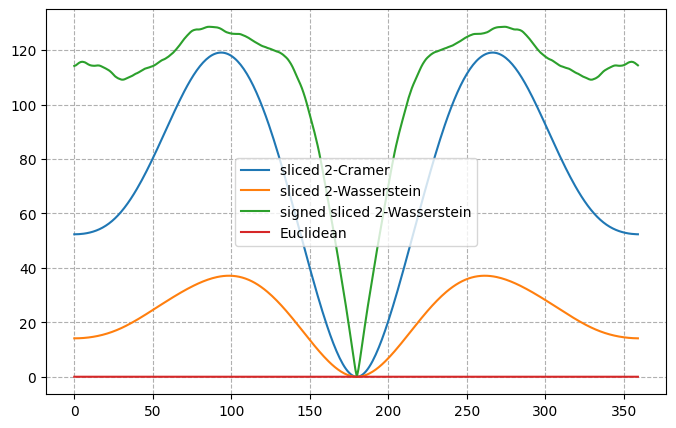

In [6]:
plt.figure(figsize=(8,5))
plt.plot(proj_angles, dists_sc2, label='sliced 2-Cramer')
plt.plot(proj_angles, dists_sw2, label='sliced 2-Wasserstein')
plt.plot(proj_angles, dists_ssw2, label='signed sliced 2-Wasserstein')
plt.plot(proj_angles, dists_l2, label='Euclidean')
plt.grid(which='major', linestyle='--')
plt.legend()
plt.show()

In [7]:
##########


# Gaussian blob Radon transform test


###########

In [8]:
L = 129

img = np.zeros((L,L))
img[L//2, L//2] = 1

sigma = 5  
g = utils.generate_centered_gaussian(L=L, d=2, sigma=sigma)
f = utils.signal_convolution(img, g)
f = f / np.sum(f)

n_points = L
proj_angles = np.linspace(0, 360, L, endpoint=False)
f_rt = transforms.Transform(f, n_points=n_points, angles=proj_angles, apply_ramp=False).radon_transform()

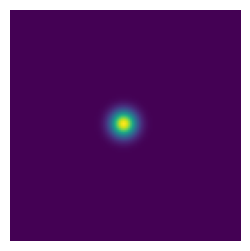

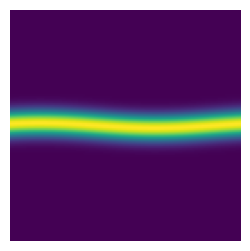

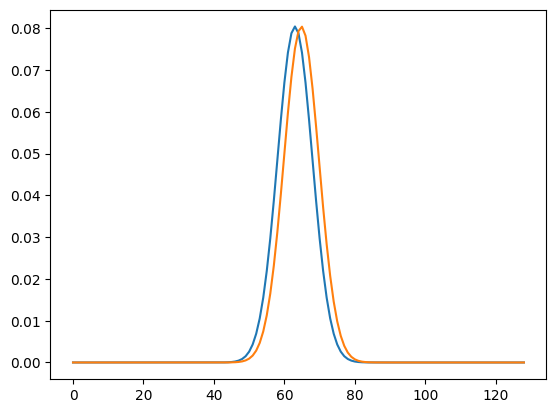

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(f)
plt.axis('off')
plt.show()
plt.figure(figsize=(3,3))
plt.imshow(f_rt[0])
plt.axis('off')
plt.show()

p = np.arange(0, L, L//5)
plt.plot(f_rt[0, :, p[0]])
plt.plot(f_rt[0, :, p[4]])
plt.show()

In [10]:
##########


# Gaussian blob Radon transform test pt. 2


###########

In [11]:
Ls = np.arange(32, 257)

Ls_odd = Ls[1::2]  # generate arrays of same size for odd and even integers between a, b
Ls_even = Ls[2::2]

err_odd = []
err_even = []

sigma = 5

for idx in range(len(Ls_odd)):

    L_o = Ls_odd[idx]
    L_e = Ls_even[idx]

    # sample points and projection angles if want to change, need to adjust Gaussian accordingly
    p_odd = L_o  
    p_even = L_e
    proj_angles_odd = np.linspace(0, 360, L_o, endpoint=False)
    proj_angles_even = np.linspace(0, 360, L_e, endpoint=False)
    
    f_o = utils.generate_centered_gaussian(L_o, d=2, sigma=sigma)  # should change width of Gaussian?
    f_e = utils.generate_centered_gaussian(L_e, d=2, sigma=sigma)
    
    f_o_rt = transforms.Transform(f_o, n_points=p_odd, angles=proj_angles_odd, apply_ramp=False).radon_transform()
    gt_o_rt = np.ones((L_o, L_o)) * np.sum(f_o, axis=0)[:, np.newaxis]  # assume this is the best discretization for projection

    f_e_rt = transforms.Transform(f_e, n_points=p_even, angles=proj_angles_even, apply_ramp=False).radon_transform()
    gt_e_rt = np.ones((L_e, L_e)) * np.sum(f_e, axis=0)[:, np.newaxis]  # assume this is the best discretization for projection

    err_odd.append(np.linalg.norm(f_o_rt[0] - gt_o_rt))
    err_even.append(np.linalg.norm(f_e_rt[0] - gt_e_rt))

err_odd = np.array(err_odd)
err_even = np.array(err_even)

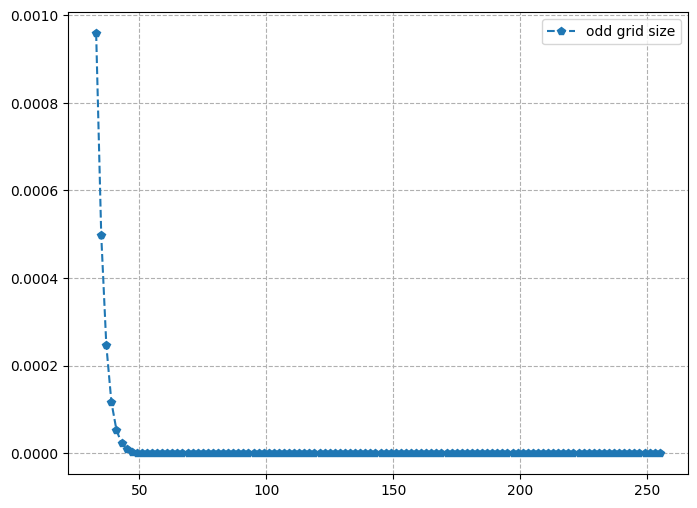

In [12]:
plt.figure(figsize=(8,6))
plt.plot(Ls_odd[:], err_odd[:], 'p--', label='odd grid size')
# plt.plot(Ls_even[:], err_even[:], 'p--', label='even grid size')
plt.grid(axis='both', linestyle='--')
plt.legend()
plt.show()

In [13]:
##########


# Interpolation for ICDF with ramp filter 


###########

In [14]:
L = 129
sigma = 10 

# proj_angles = np.arange(0, 360)
proj_angles = np.linspace(0, 360, L, endpoint=False)

p = 129  ## ** Change this to 130 and look at f_icdf_n ** ##

f = utils.generate_centered_gaussian(L, d=2, sigma=sigma)

### Apply sequential image transformations
f_nudft = transforms.Transform(f, n_points=p, angles=proj_angles, apply_ramp=True).polar_nufft()
f_rt = transforms.Transform(f, n_points=p, angles=proj_angles, apply_ramp=True).radon_transform()
f_rt_p, f_rt_n = transforms.hahn_decomposition(f_rt)
f_cdf_p, f_cdf_n = transforms.Transform(f, n_points=p, angles=proj_angles, apply_ramp=True).signed_cdf_transform()
f_icdf_p, f_icdf_n = transforms.Transform(f, n_points=p, angles=proj_angles, apply_ramp=True).signed_inverse_cdf_transform()

IMAGE


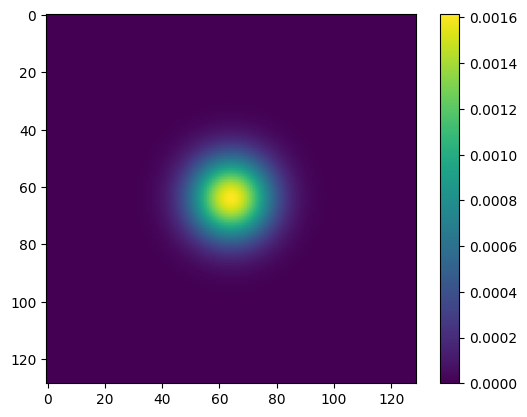


NUDFT


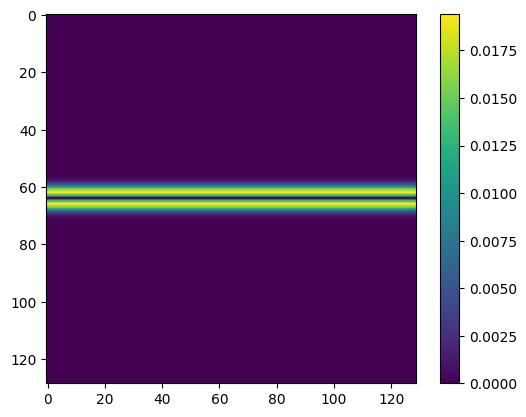


RADON TRANSFORM


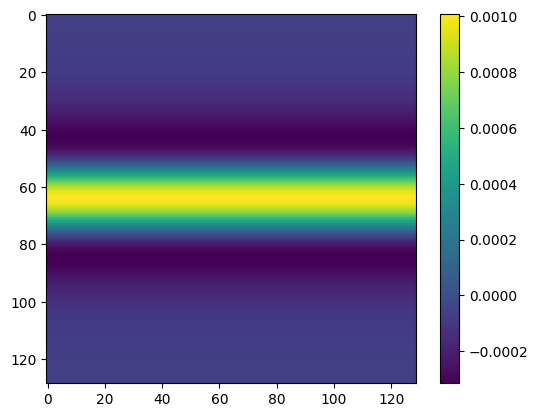


SIGNED RADON TRANSFORM


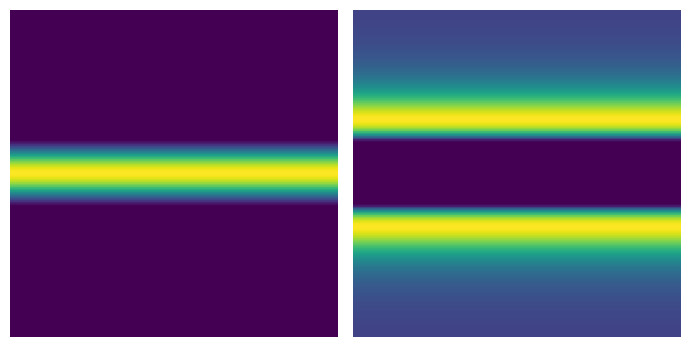


SIGNED CDF TRANSFORM


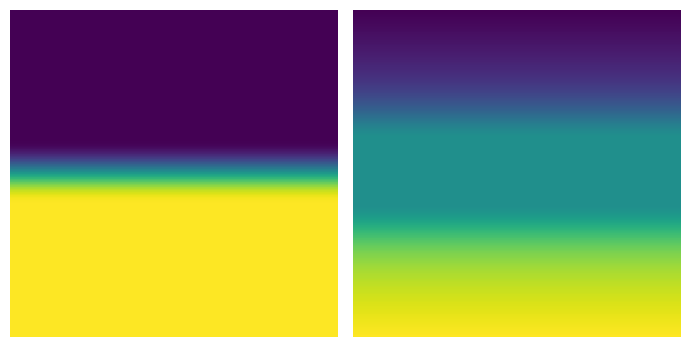


SIGNED ICDF TRANSFORM


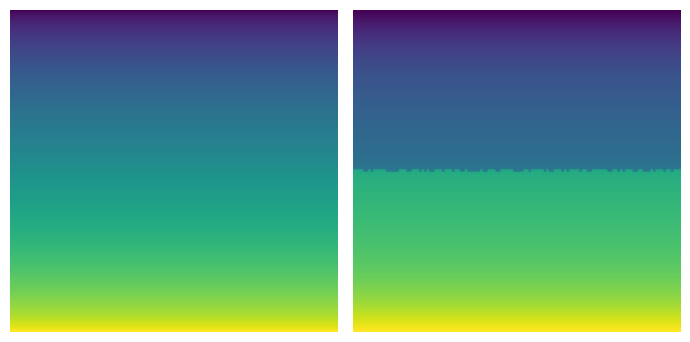

In [15]:
print("IMAGE")
plt.imshow(f)
plt.colorbar()
plt.show()

print("\nNUDFT")
plt.imshow(abs(f_nudft[0]))
plt.colorbar()
plt.show()

print("\nRADON TRANSFORM")
plt.imshow(f_rt[0])
plt.colorbar()
plt.show()

print("\nSIGNED RADON TRANSFORM")
plots.two_imshow(f_rt_p[0], abs(f_rt_n[0]))
print("\nSIGNED CDF TRANSFORM")
plots.two_imshow(f_cdf_p[0], f_cdf_n[0])
print("\nSIGNED ICDF TRANSFORM")
plots.two_imshow(f_icdf_p[0][1:-1, :], f_icdf_n[0][1:-1, :])  # note I am remove the (0, 1) edges for visualization here

In [16]:
##########


# Visualization of polar grid points


###########

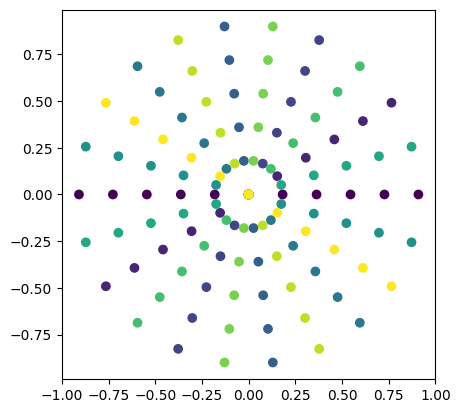

In [17]:
L = 11
image = np.zeros((L,L))

if L % 2 == 0:
    points = np.linspace(-1, 1, L, endpoint=False)
else:
    points = np.linspace(-(1 - (1/L)), 1 - (1/L), L, endpoint=True)

thetas = np.linspace(0, 2*np.pi, L, endpoint=False)

xis = []

for t in thetas:
    for p in points:
        x = p * np.cos(t)
        y = p * np.sin(t)

        xis.append([x, y])
    
xis = np.array(xis)

colors = np.array([idx for idx in range(len(points)) for _ in range(len(thetas))])  # colors correspond to the same slice

fig, ax = plt.subplots()
plt.scatter(xis[:, 0], xis[:, 1], c=colors)
ax.set_aspect('equal')